# Analysis of SD as a wave phenomenon in 2p recordings
In this script, the spreading depolarization waves are analyzed as waves of high signal, disregarding the cell dynamics, for example. Questions asked are:
* Where does the SD come from, where does it go?
* How many SDs are there (find the manually). Is this a constant over seizures for one mouse?
* Do the SDs always look similar in the same mouse?

### TODO
* T301 tmev d1 1131 (video 2): the first SD is not over yet, but the second waves are already coming. Need to make a sliding interval? I.e. on lower parts, the window for 1st SD is [x,y], for upper parts it is later [x+dt, y+dt]...
* Currently: make rectangles and take mean signal. Anything better?
* Assigning an "activation frame index": is the first maximum within the SD window. First maximum might not be the best statistic. Maybe do something with derivative (finite difference)?

## Import libraries

In [1]:
import numpy as np
from nd2_to_caiman import np_arr_from_nd2
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from math import floor, sqrt

## Open nd2 file (seizure recording)

In [2]:
nd2_fpath = fh.open_file("Select nd2 file") #"D:/PhD/Data/T386_MatlabTest/T386_20211202_green.nd2"
print(f"Input file selected: {nd2_fpath}")

Input file selected: E:/tmev/T301_tmev_d1/T301_tmev_d1.270820.1131.nd2


In [3]:
nd2_data = np_arr_from_nd2(nd2_fpath)

D:\Software\Anaconda\envs\py9\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


In [4]:
n_frames = nd2_data.shape[0]

In [5]:
nd2_data.dtype

dtype('uint16')

## Find SD waves by hand. Enter (starting frame, ending frame) into SD_frames list

In [6]:
SD_frames = [(0, 79), (55,140)]
n_SD = len(SD_frames)
#SD_frames = [(9164, 9231), (9232, 9333)]  # manually set the starting points for each wave. Last entry is the end of relevant period

## Define analysis parameters

In [7]:
# DEFINE PARAMETERS HERE:
# number of points per row and per column in the grid
n_rows = 16
n_cols = 16
# half side length of rectangle centered around points
half_side_len = 14  # if half_side_len = 3, then rectangle size = (3 + 1 + 3) x (3 + 1 + 3) = 7x7
# offset from edge of FOV. Used to 1. disregard some corner pixels, 2. give place for the rectangles around the grid points.
offset_x = 20  # ignore this many pixels on both left and right
offset_y = 20  # ignore this many pixels on both top and bottom


# DERIVED PARAMETERS:
# frame size
frame_width = nd2_data.shape[1]
frame_height = nd2_data.shape[2]
# distance between grid points
x_step = (frame_width - 2*offset_x)//(n_cols-1)
y_step = (frame_height - 2*offset_y)//(n_rows-1)
# to make grid symmetric, calculate leftover and divide it on both sides for both rows and columns
x_leftover = (frame_width - 2*offset_x)%x_step
y_leftover = (frame_height - 2*offset_y)%y_step


# TEST CONSISTENCY OF PARAMETERS
assert(n_rows > 1 and n_cols > 1)  # to be able to make a grid, need at least 2x2 points
assert((half_side_len < offset_x) and (half_side_len < offset_y))  # make sure that the rectangles stay inside FOV
assert(((2*half_side_len + 1) < x_step) and ((2*half_side_len + 1) < y_step ))  # check no overlap between rectangles

## Create array of grid points

In [8]:
def get_x(i_col):
    return (offset_x + floor(x_leftover/2) + i_col*x_step)

def get_y(i_row):
    return (offset_y + floor(y_leftover/2) + i_row*y_step)

def get_coords(i_row, i_col): 
    """
    given the input video and needed grid size, get coordinates of the grid point as tuple (row_pixel, col_pixel).
    IMPORTANT: it uses the parameters defined above! Changing them will change the output of this function.
    """
    return (get_x(i_col), get_y(i_row))

points = []  # list of grid points: [(x, y), ...]
for i_row in range(n_cols):
    for i_col in range(n_rows):
        points.append(get_coords(i_row,i_col))
    
points_x = []
points_y = []
# list x and y coordinates.
for i_col in range(n_cols):
    points_x.append(get_x(i_col))
for i_row in range(n_rows):
    points_y.append(get_y(i_row))

## Show grid on recording

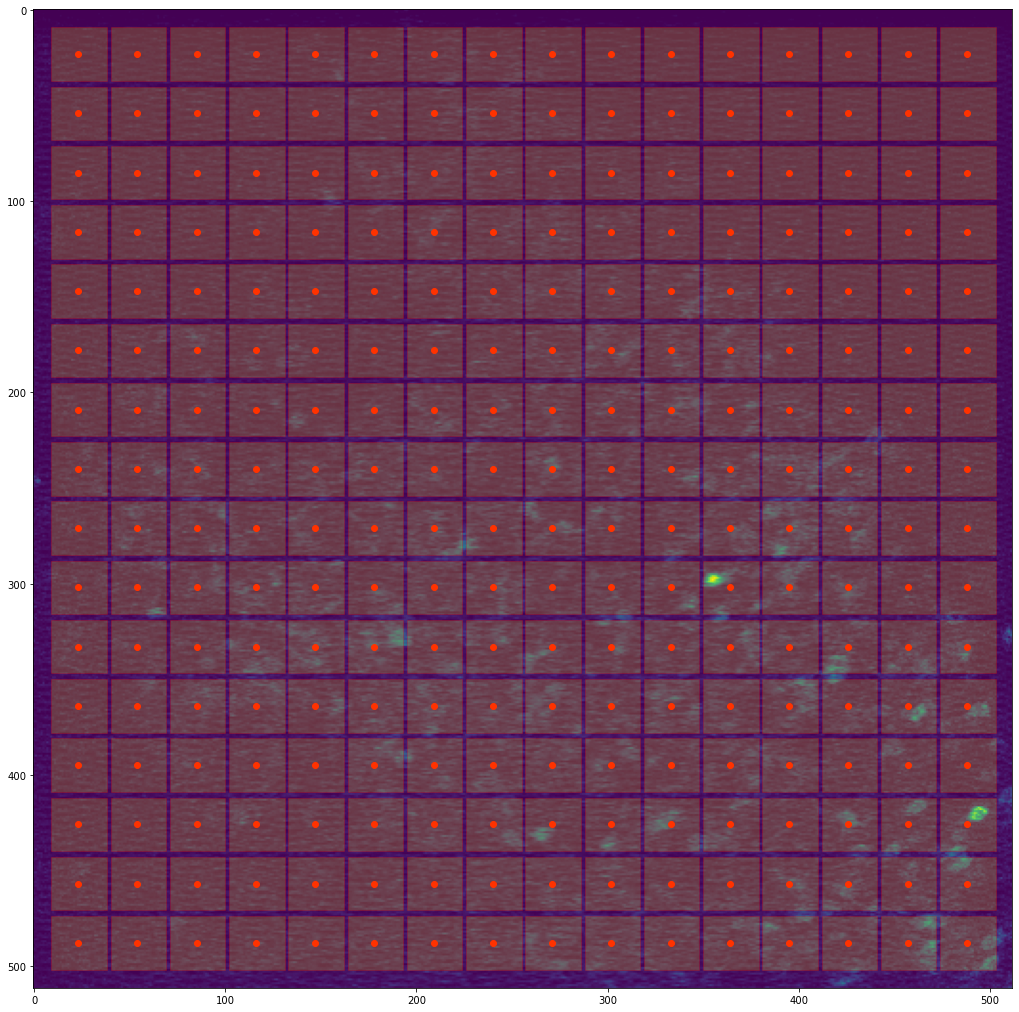

In [9]:
rects = [Rectangle((points[i][0] - half_side_len, points[i][1] - half_side_len ), (2*half_side_len+1), (2*half_side_len))
                  for i in range(len(points))]
pc = PatchCollection(rects, facecolor="yellow", alpha=0.2, edgecolor="red")
fig, ax = plt.subplots(1, figsize=(18,18))
plt.imshow(nd2_data[0,:,:])
plt.scatter(*zip(*points), color='red')
ax.add_collection(pc)
plt.show()

### Test getCoord()

In [10]:
test_getCoord = False
if test_getCoord:
    fig = plt.figure(figsize=(18,18))
    plt.imshow(nd2_data[0,:,:])
    plt.scatter(*zip(*points[:5]), color='red')  # should start filling up row after row, from top left.
    plt.show()

# Get grid signal. Run 1 or 2.

In [11]:
def normalize_trace(traces):
    traces_norm = np.empty(traces.shape, dtype=np.float64)
    max_arr = np.empty((n_rows, n_cols),  dtype=nd2_data.dtype)
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            max_arr[i_row, i_col] = max(traces[:, i_row, i_col])
            for i_frame in range(n_frames):
                traces_norm[i_frame, i_row, i_col] = traces[i_frame, i_row, i_col]/max_arr[i_row, i_col]
    return (traces_norm, max_arr)

## 1. Calculate traces by using one of the commented-out methods
1. use single pixel as source of data
2. use average of a rectangle
3. use median of a rectangle

In [ ]:
traces = np.empty((n_frames, n_rows, n_cols), dtype=nd2_data.dtype)
# todo: check if row and column indices are correct! change np original array, check where it changes on plot
for i_frame in range(n_frames): 
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            # middle point of rectangle to sample from
            x, y = get_coords(i_row, i_col)
            # get trace data
            # 1. simply use data of point:
            # traces[i_frame, i_row, i_col] = nd2_data[i_frame, x, y]
            # 2. use the average of a rectangle centered around point:
            # traces[i_frame, i_row, i_col] = nd2_data[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1].mean()
            # 3. use median of the rectangle:
            traces[i_frame, i_row, i_col] = np.median(nd2_data[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
# create normalized traces
traces_norm, max_arr = normalize_trace(traces)

## 2. Get derivative (difference) signal
1. Use derivative signal of single pixels
2. use derivative signal of mean of rectangles
3. use derivative signal of median of rectangles

In [13]:
traces = np.zeros((n_frames, n_rows, n_cols), dtype=int)
nd2_unsigned = nd2_data.astype(np.int32)
# todo: check if row and column indices are correct! change np original array, check where it changes on plot
for i_frame in range(1, n_frames):
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            # middle point of rectangle to sample from
            x, y = get_coords(i_row, i_col)
            # get trace data
            # 1. simply use data of point:
            #races[i_frame, i_row, i_col] = nd2_unsigned[i_frame, x, y] - nd2_unsigned[i_frame-1, x, y]
            # 2. use average of a rectangle: to be implemented. FIXME: invalid value encountered in traces_norm (normalize_trace below)
            #f_t1 = np.mean(nd2_unsigned[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
            #f_t0 = np.mean(nd2_unsigned[i_frame-1, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
            #traces[i_frame, i_row, i_col] = f_t1 - f_t0
            # 3. use median of a rectangle:
            f_t1 = np.median(nd2_unsigned[i_frame, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
            f_t0 = np.median(nd2_unsigned[i_frame-1, x-half_side_len:x+half_side_len+1, y-half_side_len:y+half_side_len+1])
            traces[i_frame, i_row, i_col] = f_t1 - f_t0
# normalize traces
traces_norm, max_arr = normalize_trace(traces)            

# Visualize results

### Plot normalized traces per grid. (For high n_rows and n_cols, this might take long!)

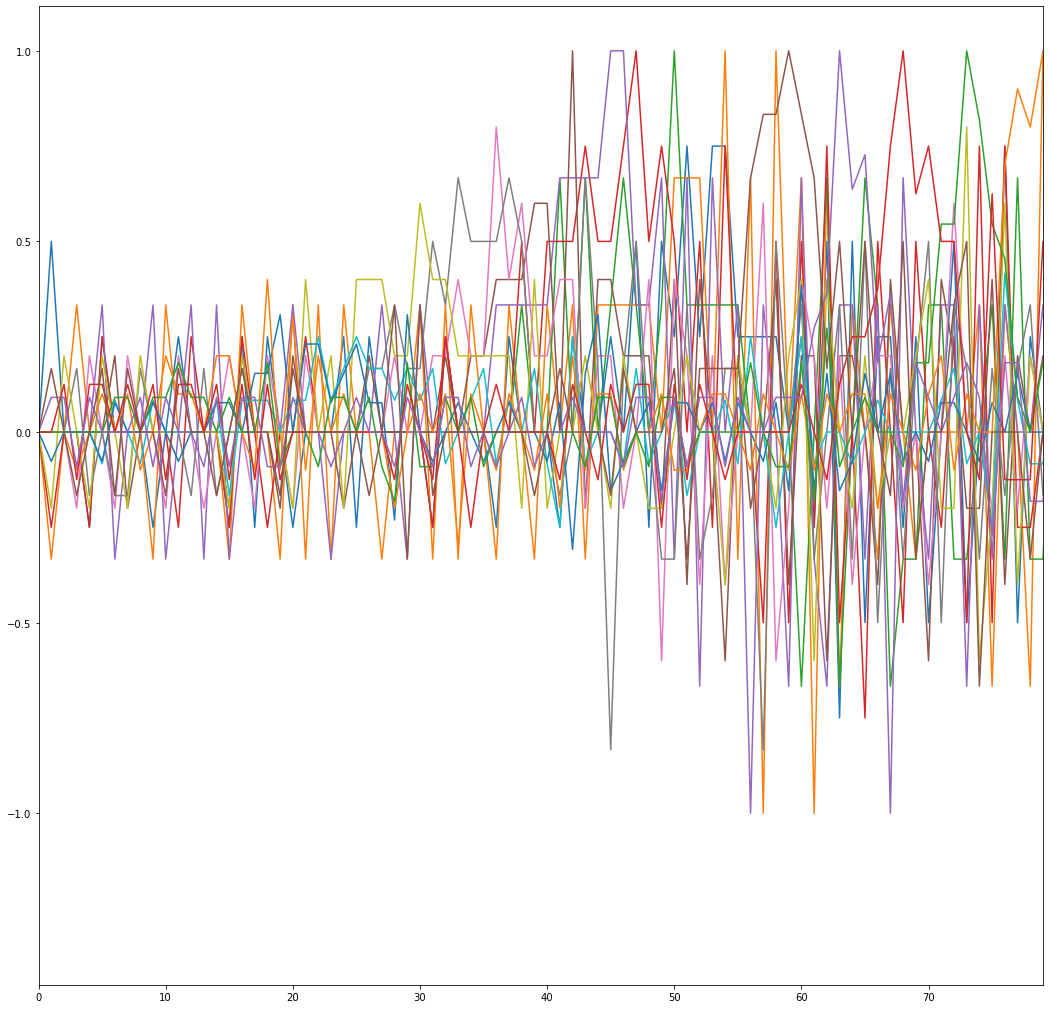

In [14]:
plot_norm_traces = True
if plot_norm_traces:
    fig = plt.figure(figsize = (18,18))
    for i_row in range(1):
        for i_col in range(n_cols):
            plt.plot(traces_norm[:, i_row, i_col])
    plt.xlim(SD_frames[0])
    plt.show()

In [15]:
def showGridPoint(i_row, i_col):
    """
    Show the grid point that corresponds to i_row and i_col. i_row and i_col start from 0!
    """
    i_selected = i_row*n_cols + i_col  # 2d index to 1d index
    fig, ax = plt.subplots(1, figsize=(18,18))
    plt.imshow(nd2_data[0,:,:])
    plt.scatter(*zip(*points), color='blue')
    # define rectangles not selected
    rects = [Rectangle((points[i][0] - half_side_len, points[i][1] - half_side_len ), (2*half_side_len+1), (2*half_side_len))
                  for i in range(len(points)) if i != i_selected]
    pc1 = PatchCollection(rects, facecolor="yellow", alpha=0.2, edgecolor="red")
    # define selected rectangle
    rect_sel = [Rectangle((points[i_selected][0] - half_side_len, points[i_selected][1] - half_side_len ), (2*half_side_len+1), (2*half_side_len))]
    pc2 = PatchCollection(rect_sel, facecolor="yellow", alpha=0.6, edgecolor="blue")
    plt.scatter(*get_coords(i_row, i_col), color='red')
    ax.add_collection(pc1)
    ax.add_collection(pc2)
    plt.show()

# test the showGridPoint function
testShowGridPoint = False
if testShowGridPoint:
    showGridPoint(13, 10)

In [16]:
onset_grid = np.zeros((n_SD, n_rows, n_cols), dtype='uint16')  # length of SD_frames is n_SD + 1 (last entry is end of relevant interval)
for i_row in range(n_rows): 
    for i_col in range(n_cols):
        for i_SD in range(n_SD):
            max_frames = np.where(traces_norm[SD_frames[i_SD][0]:SD_frames[i_SD][1], i_row, i_col] == max(traces_norm[SD_frames[i_SD][0]:SD_frames[i_SD][1], i_row, i_col]), 1, 0).nonzero()[0]
            if len(max_frames) > 1:  # more maxima found
                print(f"{len(max_frames)} maxima of grid point {i_row}, {i_col} in SD #{i_SD+1}")
            elif len(max_frames) == 0:
                print(f"No max frames!")
            max_frame = max_frames[0]  # TODO: how to select between maxima? Use info from neighbours?
            onset_grid[i_SD, i_row, i_col] = max_frame + SD_frames[i_SD][0]  # adjust to whole recording again. TODO: off-by-one error?
        

4 maxima of grid point 0, 0 in SD #1
2 maxima of grid point 0, 1 in SD #1
3 maxima of grid point 0, 1 in SD #2
13 maxima of grid point 0, 2 in SD #2
2 maxima of grid point 0, 4 in SD #1
2 maxima of grid point 0, 4 in SD #2
4 maxima of grid point 0, 5 in SD #2
3 maxima of grid point 0, 7 in SD #1
2 maxima of grid point 0, 8 in SD #2
7 maxima of grid point 1, 0 in SD #1
14 maxima of grid point 1, 0 in SD #2
3 maxima of grid point 1, 1 in SD #1
2 maxima of grid point 1, 1 in SD #2
2 maxima of grid point 1, 2 in SD #1
9 maxima of grid point 1, 2 in SD #2
3 maxima of grid point 1, 3 in SD #1
2 maxima of grid point 1, 3 in SD #2
2 maxima of grid point 1, 8 in SD #1
3 maxima of grid point 1, 8 in SD #2
2 maxima of grid point 1, 10 in SD #1
2 maxima of grid point 1, 11 in SD #1
2 maxima of grid point 1, 11 in SD #2
2 maxima of grid point 1, 12 in SD #1
2 maxima of grid point 1, 12 in SD #2
2 maxima of grid point 1, 13 in SD #1
2 maxima of grid point 1, 13 in SD #2
2 maxima of grid point 1, 14 

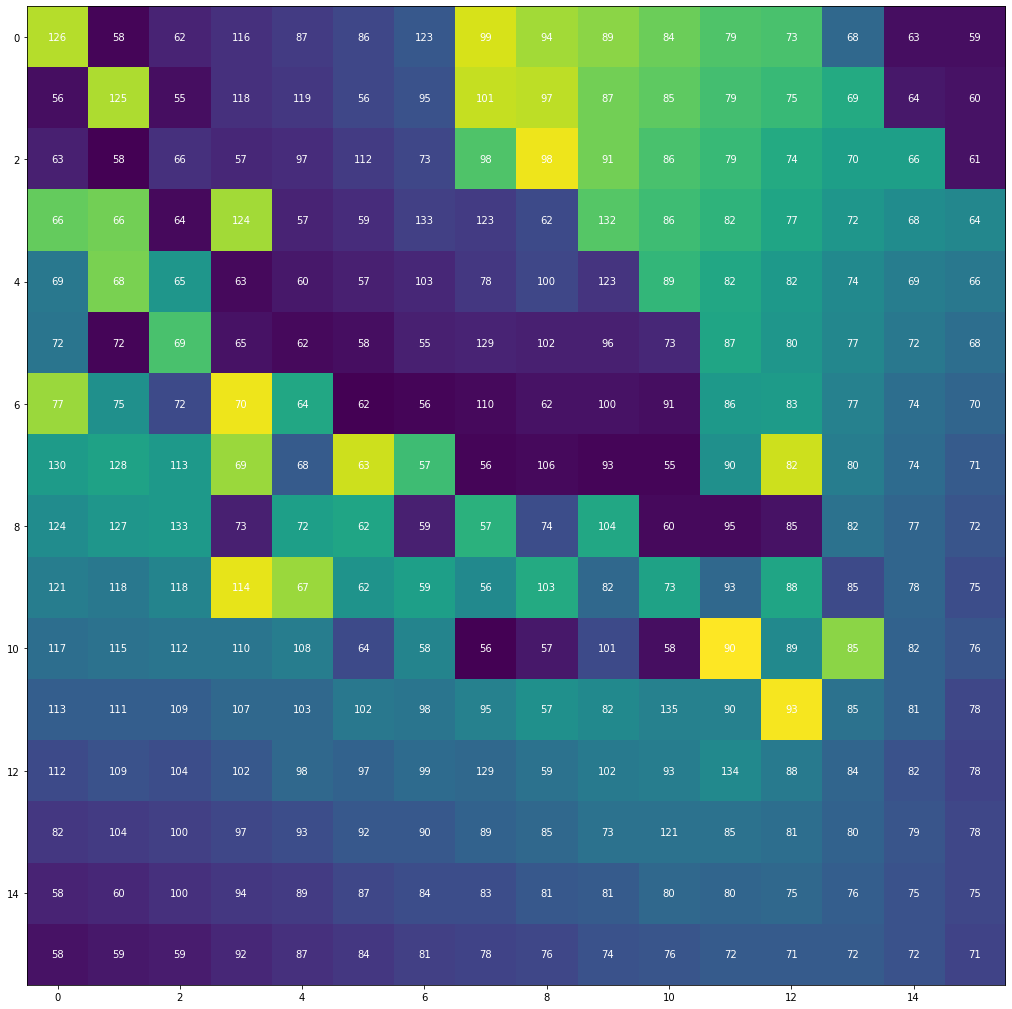

In [19]:
i_SD = 1
fig, ax = plt.subplots(figsize = (18, 18))
plt.imshow(onset_grid[i_SD, :, :].transpose())  # transpose because imshow expects (x, y), and we provide (row, col) shape
for i in range(n_rows):
    for j in range(n_cols):
        text = ax.text(j, i, onset_grid[i_SD, i, j],
                       ha="center", va="center", color="w")
plt.show()

In [18]:
def getNeighbours(i_row, i_col):
    neighbours_list = []  # [(x, y), ...] format
    for i_row_nb in range(i_row-1, i_row +2):
        for i_col_nb in range(i_col-1, i_col+2):
            if (i_row_nb >= 0) and (i_row_nb < n_rows) and (i_col_nb >= 0) and (i_col_nb < n_cols):
                if not((i_row_nb == i_row) and (i_col_nb == i_col) ):  # exclude cell itself
                    neighbours_list.append((i_col_nb, i_row_nb))  # format is (x, y)
    return neighbours_list

In [ ]:
def getVectors(i_SD):
    vectors_x = np.zeros((n_rows, n_cols), float)
    vectors_y = np.zeros((n_rows, n_cols), float)
    weights = onset_grid[i_SD, :, :]
    for i_row in range(n_rows):  # y coordinate of cell
        for i_col in range(n_cols):  # x coordinate of cell
            mean_x = 0
            mean_y = 0
            neighbours =  getNeighbours(i_row, i_col)
            # loop over neighbouring rectangles. get average vector by weighted sum of the normalized vectors.
            for x, y in neighbours:
                norm_factor = 1/sqrt(pow(x-i_col, 2) + pow(y-i_row, 2))
                weight = weights[x, y]
                mean_x += x*norm_factor*weight
                mean_y += y*norm_factor*weight
            mean_x = mean_x/len(neighbours)
            mean_y = mean_y/len(neighbours)
            vectors_x[i_row, i_col] = mean_x
            vectors_y[i_row, i_col] = mean_y
    return (vectors_x, vectors_y)
            
            
            

In [ ]:
def getVectors(i_SD):
    vectors_x = np.zeros((n_rows, n_cols), float)
    vectors_y = np.zeros((n_rows, n_cols), float)
    weights = onset_grid[i_SD, :, :]
    # loop through each neighbor, find max weight, point that direction
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            x = 0
            y = 0
            neighbours = getNeighbours(i_col, i_row)
            current_max_weight = weights[i_row, i_col]
            for x_n, y_n in neighbours:
                if weights[y, x] > current_max_weight:
                    current_max_weight = weights[y, x]
                    x = x_n
                    y = y_n
            norm_factor = sqrt(x**2 + y**2)
            if norm_factor == 0:
                norm_factor = 1
            vectors_x[i_row, i_col] = x/norm_factor
            vectors_y[i_row, i_col] = y/norm_factor
    return (vectors_x, vectors_y)

# TODO: implement weighting and plot quiver
* https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html
* fix first getVectors that averages neighbors.
* try to rotate plot so that it matches video recording and imshow plot..

In [ ]:
quiv_x, quiv_y = getVectors(1)
fig = plt.figure(figsize=(18,18))
plt.quiver(points_x, points_y, quiv_x, quiv_y)
plt.show()

# TODO: sliding SD window (to be able to deal with intersections between SDs)